# Global Search Demo

In this demo, we'll step by step analyze MS GraphRAG paper's Graph Index to be persistent into NebulaGraph, and then implement Retrievers over such Graph Index for global and local query tasks.

## Graph Data Preparation

For this Demo, we leverage the extracted and processed data from the [GraphRAG](https://github.com/microsoft/graphrag) project.

In [134]:
import pandas as pd

# df_community_reports = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_community_reports.parquet")
# df_covariates = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_covariates.parquet")
# df_entities = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_entities.parquet")
# df_nodes = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_nodes.parquet")
# df_relationships = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_relationships.parquet")
# df_text_units = pd.read_parquet("https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_text_units.parquet")

# print("> df_community_reports")
# df_community_reports.info()
# print("\n\n> df_covariates")
# df_covariates.info()
# print("\n\n> df_entities")
# df_entities.info()
# print("\n\n> df_nodes")
# df_nodes.info()
# print("\n\n> df_relationships")
# df_relationships.info()
# print("\n\n> df_text_units")
# df_text_units.info()


The printout shows the data schema of the extracted data.

> df_community_reports

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   community          6 non-null      object 
 1   full_content       6 non-null      object 
 2   level              6 non-null      int64  
 3   rank               6 non-null      float64
 4   title              6 non-null      object 
 5   rank_explanation   6 non-null      object 
 6   summary            6 non-null      object 
 7   findings           6 non-null      object 
 8   full_content_json  6 non-null      object 
 9   id                 6 non-null      object 
dtypes: float64(1), int64(1), object(8)
memory usage: 612.0+ bytes
```

> df_entities

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     217 non-null    object
 1   name                   217 non-null    object
 2   type                   217 non-null    object
 3   description            217 non-null    object
 4   human_readable_id      217 non-null    int64 
 5   graph_embedding        0 non-null      object
 6   text_unit_ids          217 non-null    object
 7   description_embedding  217 non-null    object
dtypes: int64(1), object(7)
memory usage: 13.7+ KB
```


> df_relationships

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             276 non-null    object 
 1   target             276 non-null    object 
 2   weight             276 non-null    float64
 3   description        276 non-null    object 
 4   text_unit_ids      276 non-null    object 
 5   id                 276 non-null    object 
 6   human_readable_id  276 non-null    object 
 7   source_degree      276 non-null    int64  
 8   target_degree      276 non-null    int64  
 9   rank               276 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 21.7+ KB
```

> df_text_units

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                12 non-null     object
 1   text              12 non-null     object
 2   n_tokens          12 non-null     int64 
 3   document_ids      12 non-null     object
 4   entity_ids        12 non-null     object
 5   relationship_ids  12 non-null     object
 6   covariate_ids     12 non-null     object
dtypes: int64(1), object(6)
memory usage: 804.0+ bytes
```


### Entity Type Analysis

Let's first load the data and see the type distribution.

In [4]:
import pandas as pd

df_entities = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_entities.parquet"
)

We can see the data schema of df_entities, and its type distribution, besides the type distribution, we also see the sample data of each type.

Then we simply fill the empty type with the guessed type(quite rough).

**Entity Type Distribution**

                          Type  Count                       Sample Name                                    Sample Description  Sample Human Readable ID Sample Text Unit IDs
                        PERSON     97                       ALEX MERCER Alex Mercer is a character with a military backgro...                         0               ['0...
                       CONCEPT     90         EXTRATERRESTRIAL RESEARCH The study of extraterrestrial life forms and their...                        96               ['2...
                                    5    EXTRATERRESTRIAL COMMUNICATION                                                   ...                       101               ['2...
                         EVENT      4                  OPERATION: DULCE Operation: Dulce is a secretive mission undertaken...                         5               ['2...
                           GEO      4               DULCE MILITARY BASE The Dulce Military Base is a pivotal location in t...          

**Visualization of Entity Type Distribution**

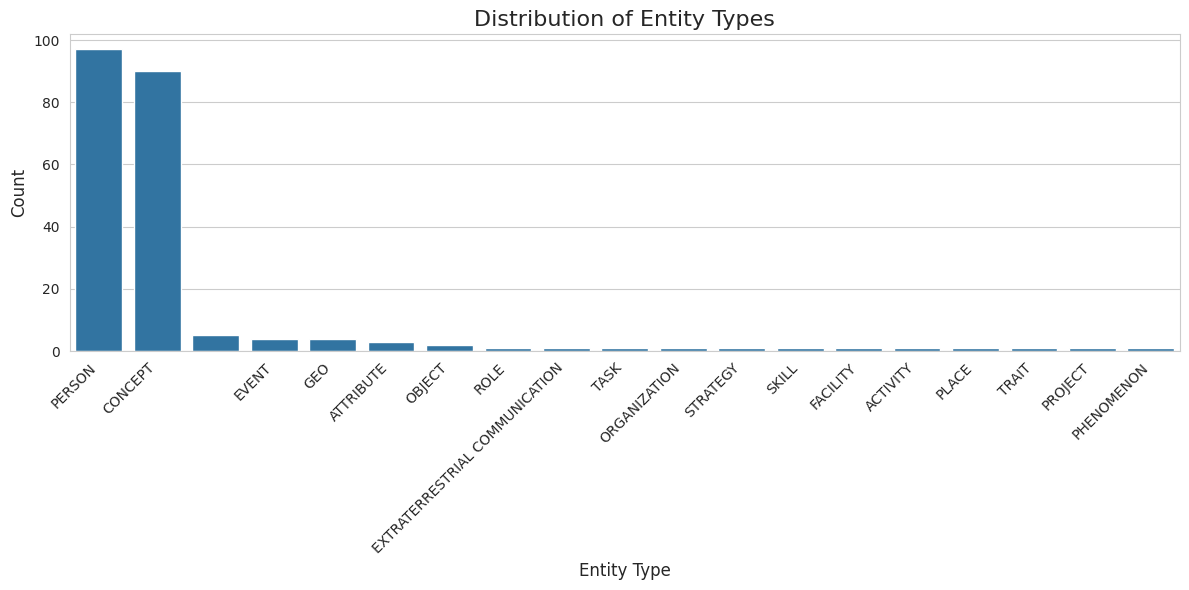

**Total Number of Entities**


Total number of entities: 217


**Entity Type Guessing Function**

**Applying Entity Type Guessing**

**Updated Entity Type Distribution**


Updated entity type distribution:
type
PERSON                            98
CONCEPT                           90
EVENT                              4
MISCELLANEOUS                      4
GEO                                4
ATTRIBUTE                          3
OBJECT                             2
PROJECT                            1
TRAIT                              1
SKILL                              1
PLACE                              1
ACTIVITY                           1
FACILITY                           1
ROLE                               1
STRATEGY                           1
ORGANIZATION                       1
TASK                               1
EXTRATERRESTRIAL COMMUNICATION     1
PHENOMENON                         1
Name: count, dtype: int64


**Visualization of Updated Entity Type Distribution**

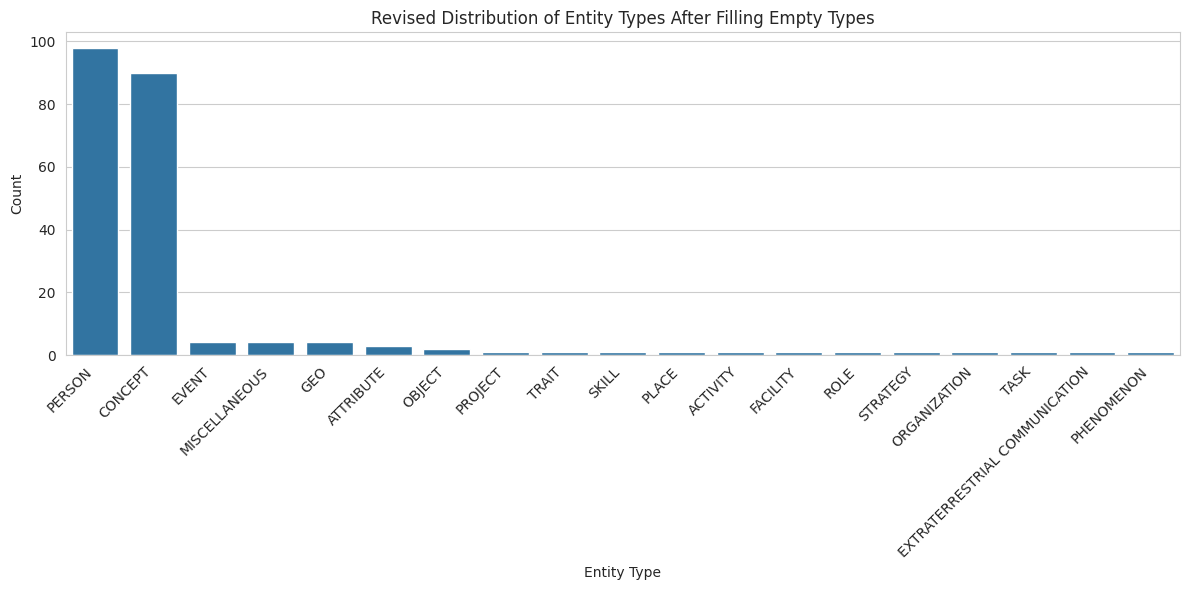

In [5]:
## Raw Data Schema

#  #   Column                 Non-Null Count  Dtype
# ---  ------                 --------------  -----
#  0   id                     217 non-null    object
#  1   name                   217 non-null    object
#  2   type                   217 non-null    object
#  3   description            217 non-null    object
#  4   human_readable_id      217 non-null    int64
#  5   graph_embedding        0 non-null      object
#  6   text_unit_ids          217 non-null    object  ----------- For connection to text units
#  7   description_embedding  217 non-null    object  ----------- Embedding for description, we don't use it

from IPython.display import display, Markdown

display(Markdown("**Entity Type Distribution**"))

# Get all types of df_entities and their counts
type_counts = df_entities["type"].value_counts().sort_values(ascending=False)

# Create a DataFrame with type information and sample data
type_info = []
for entity_type in type_counts.index:
    sample = df_entities[df_entities["type"] == entity_type].iloc[0]
    type_info.append(
        {
            "Type": entity_type,
            "Count": type_counts[entity_type],
            "Sample Name": sample["name"],
            "Sample Description": sample["description"][:50] + "...",
            "Sample Human Readable ID": sample["human_readable_id"],
            "Sample Text Unit IDs": str(sample["text_unit_ids"])[:3] + "...",
        }
    )

# Create and display the DataFrame
df_type_info = pd.DataFrame(type_info)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print(df_type_info.to_string(index=False))

display(Markdown("**Visualization of Entity Type Distribution**"))

# Visualize the graph
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set_style("whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot
sns.barplot(x="Type", y="Count", data=df_type_info, ax=ax)

# Customize the plot
ax.set_title("Distribution of Entity Types", fontsize=16)
ax.set_xlabel("Entity Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

display(Markdown("**Total Number of Entities**"))

# Print total number of entities
total_entities = df_type_info["Count"].sum()
print(f"\nTotal number of entities: {total_entities}")

display(Markdown("**Entity Type Guessing Function**"))

# Function to guess entity type based on name and description
def guess_entity_type(row):
    name = row["name"].lower()
    description = row["description"].lower()

    type_keywords = {
        "PERSON": ["person", "individual", "mr", "mrs", "ms", "dr"],
        "ORGANIZATION": [
            "company",
            "organization",
            "corporation",
            "agency",
            "institute",
        ],
        "PLACE": ["city", "country", "place", "region", "area"],
        "EVENT": ["event", "incident", "occurrence", "happening"],
        "PRODUCT": ["product", "item", "goods"],
        "CONCEPT": ["concept", "idea", "theory", "principle"],
    }

    for entity_type, keywords in type_keywords.items():
        # I know, this is a quite rough guess, we will improve it later :-P
        if any(keyword in name or keyword in description for keyword in keywords):
            return entity_type
    return "MISCELLANEOUS"  # Default type if no match found


display(Markdown("**Applying Entity Type Guessing**"))

# Apply the guessing function to rows with empty type or empty string
df_entities.loc[
    (df_entities["type"].isna()) | (df_entities["type"] == ""), "type"
] = df_entities[(df_entities["type"].isna()) | (df_entities["type"] == "")].apply(
    guess_entity_type, axis=1
)

display(Markdown("**Updated Entity Type Distribution**"))

# Check the updated type distribution
updated_type_counts = df_entities["type"].value_counts()
print("\nUpdated entity type distribution:")
print(updated_type_counts)

display(Markdown("**Visualization of Updated Entity Type Distribution**"))

# Visualize the updated distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=updated_type_counts.index, y=updated_type_counts.values)
plt.title("Revised Distribution of Entity Types After Filling Empty Types")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [6]:
# Let's see all MISCELLANEOUS and EXTRATERRESTRIAL COMMUNICATION items' names and descriptions
# pd.concat([
#     df_entities[df_entities['type'] == 'MISCELLANEOUS'][['name', 'description']].head(10),
#     df_entities[df_entities['type'] == 'EXTRATERRESTRIAL COMMUNICATION'][['name', 'description']].head(10)
# ])

# We can see 95: OPERATIVE JESS("ENTITY" CONCEPT... seems like a dirty data, but we will keep it for now.
# We will remove it later if it causes trouble.

#### Schema Design

Now, let's create NebulaGraph DDL to create TAGs per entity type.

We just generate the DDL and print it out.

```text
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     217 non-null    object
 1   name                   217 non-null    object
 2   type                   217 non-null    object
 3   description            217 non-null    object
 4   human_readable_id      217 non-null    int64 
 5   graph_embedding        0 non-null      object
 6   text_unit_ids          217 non-null    object
 7   description_embedding  217 non-null    object

Type       Count  Sample Name             Sample Description                Sample Human Readable ID  Sample Text Unit IDs
PERSON        97  ALEX MERCER             Alex Mercer is a character...                            0  ['0...
CONCEPT       90  EXTRATERRESTRIAL R...   The study of extraterrestr...                           96  ['2...
EVENT          4  OPERATION: DULCE        Operation: Dulce is a secr...                            5  ['2...
GEO            4  DULCE MILITARY BASE     The Dulce Military Base is...                          116  ['6...
ATTRIBUTE      3  STRATEGIC MINDSET       The approach of carefully ...                          172  ['1...
OBJECT         2  DRONE                   A drone is encountered by ...                          107  ['6...
ROLE           1  OPERATION OVERSIGHT     The responsibility of supe...                          176  ['1...
TASK           1  ALIEN CODE DECIPHERING  The activity that Dr. Jord...                          169  ['1...
```

We could leverage the multi-tagging feature of NebulaGraph to:

- Create TAGs per entity type with its type as TAG name
    - properties:
        - name
        - human_readable_id
- Add a meta TAG `__Entity` to all entities to help scope the search namespace, indexing semantic template, etc.
    - properties:
        - name
        - human_readable_id
        - type
        - description
- Vertex ID: `entity_{human_readable_id}`

> Also, we could see here the `text_unit_ids` is a list of text unit ids, this will be EDGEs between `entity` and `text_unit`
>
> Here `text_unit` is no longer a Knowledge-Level Vertex in our Graph Index, but a Meta-Level Vertex, which is the raw Texutal Doc Snippet.
>
> We will come back to this later.

Now, let's create NebulaGraph DDL to create TAGs per entity type.

In [139]:
# Generate DDL for entity types
entity_types = df_entities["type"].unique()

ddl_statements = [
    "CREATE TAG IF NOT EXISTS `__Entity` (name string, human_readable_id int, type string, description string);\n\n"
]

for entity_type in entity_types:
    ddl = f"""CREATE TAG IF NOT EXISTS `{entity_type.replace(' ', '_')}` (name string, human_readable_id int);
"""
    ddl_statements.append(ddl)

# Print all DDL statements
print("NebulaGraph DDL Statements for Knowledge-Level Graph:")
print("".join(ddl_statements))

NebulaGraph DDL Statements for Knowledge-Level Graph:
CREATE TAG IF NOT EXISTS `__Entity` (name string, human_readable_id int, type string, description string);

CREATE TAG IF NOT EXISTS `PERSON` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ORGANIZATION` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `EVENT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `EXTRATERRESTRIAL_COMMUNICATION` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `CONCEPT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `MISCELLANEOUS` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `OBJECT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `GEO` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `TASK` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `FACILITY` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ATTRIBUTE` (name string, human_readable_id int);
CREATE TA

Before we load the data, we need to persist the data into different tabular ones by TAG, with our desired vertex id and properties fields like:

| Vertex ID | Name | Description | Human Readable ID | Type |
| --------- | ---- | ----------- | ----------------- | ---- |
| entity_0  | ALEX MERCER                    | Alex Mercer is a character with a military backgro... | 0 | PERSON |
| entity_1  | EXTRATERRESTRIAL RESEARCH      | The study of extraterrestrial life forms and their... | 1 | CONCEPT |
| entity_2  | OPERATION: DULCE               | Operation: Dulce is a secretive mission undertaken... | 2 | EVENT |
| entity_3  | DULCE MILITARY BASE            | The Dulce Military Base is a pivotal location in t... | 3 | GEO |
| entity_4  | STRATEGIC MINDSET              | The approach of carefully considering the broader ... | 4 | ATTRIBUTE |




In [148]:
# Persist data into multiple csv files named by TAG_{TAG}.csv
import pandas as pd
import os

# Create a directory to store the CSV files
os.makedirs("data", exist_ok=True)

# Group the dataframe by 'type'
grouped = df_entities.groupby("type")

# Iterate through each group and save as a separate CSV file
for tag, group in grouped:
    tag_name = str(tag).replace(" ", "_")

    # Create a new dataframe with the desired columns
    df_tag = pd.DataFrame(
        {
            "Vertex ID": "entity_" + group["human_readable_id"].astype(str),
            "Name": group["name"].astype(str),
            "Description": group["description"].astype(str),
            "Human Readable ID": group["human_readable_id"].astype(int),
            "Type": tag_name,
        }
    )

    # Save the dataframe as a CSV file
    csv_filename = f"data/TAG_{tag_name}.csv"
    df_tag.to_csv(csv_filename, index=False)
    # print(f"Saved {csv_filename}")

print("All TAG CSV files have been created.")

# Print ng_load commands for each TAG file
for tag in df_entities["type"].unique():
    tag_name = str(tag).replace(" ", "_")
    ng_load_command_entity = f"%ng_load --header --source data/TAG_{tag_name}.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper"
    ng_load_command_type = f"%ng_load --header --source data/TAG_{tag_name}.csv --tag {tag_name} --vid 0 --props 1:name,3:human_readable_id --space ms_paper"
    print(ng_load_command_entity)
    print(ng_load_command_type)

All TAG CSV files have been created.
%ng_load --header --source data/TAG_PERSON.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_PERSON.csv --tag PERSON --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_ORGANIZATION.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_ORGANIZATION.csv --tag ORGANIZATION --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_EVENT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_EVENT.csv --tag EVENT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_EXTRATERRESTRIAL_COMMUNICATION.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space m

#### Load Entities Data to NebulaGraph

##### Connect to NebulaGraph

In [ ]:
# %pip install jupyter-nebulagraph
%load_ext ngql
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula

##### Create Space

In [ ]:
%ngql CREATE SPACE IF NOT EXISTS ms_paper (partition_num=1, replica_factor=1, vid_type=FIXED_STRING(128));

In [ ]:
!sleep 20
%ngql USE ms_paper

##### Create TAGs

In [145]:
%%ngql

CREATE TAG IF NOT EXISTS `__Entity` (name string, human_readable_id int, type string, description string);

CREATE TAG IF NOT EXISTS `PERSON` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ORGANIZATION` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `EVENT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `EXTRATERRESTRIAL_COMMUNICATION` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `CONCEPT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `MISCELLANEOUS` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `OBJECT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `GEO` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `TASK` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `FACILITY` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ATTRIBUTE` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `STRATEGY` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ROLE` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `PROJECT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `ACTIVITY` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `PLACE` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `SKILL` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `TRAIT` (name string, human_readable_id int);
CREATE TAG IF NOT EXISTS `PHENOMENON` (name string, human_readable_id int);


""


In [146]:
!sleep 20
%ngql SHOW TAGS;

,Name
0,ACTIVITY
1,ATTRIBUTE
2,CONCEPT
3,EVENT
4,EXTRATERRESTRIAL_COMMUNICATION
5,FACILITY
6,GEO
7,MISCELLANEOUS
8,OBJECT
9,ORGANIZATION


In [149]:

%ng_load --header --source data/TAG_PERSON.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_PERSON.csv --tag PERSON --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_ORGANIZATION.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_ORGANIZATION.csv --tag ORGANIZATION --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_EVENT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_EVENT.csv --tag EVENT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_EXTRATERRESTRIAL_COMMUNICATION.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_EXTRATERRESTRIAL_COMMUNICATION.csv --tag EXTRATERRESTRIAL_COMMUNICATION --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_CONCEPT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_CONCEPT.csv --tag CONCEPT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_MISCELLANEOUS.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_MISCELLANEOUS.csv --tag MISCELLANEOUS --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_OBJECT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_OBJECT.csv --tag OBJECT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_GEO.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_GEO.csv --tag GEO --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_TASK.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_TASK.csv --tag TASK --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_FACILITY.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_FACILITY.csv --tag FACILITY --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_ATTRIBUTE.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_ATTRIBUTE.csv --tag ATTRIBUTE --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_STRATEGY.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_STRATEGY.csv --tag STRATEGY --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_ROLE.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_ROLE.csv --tag ROLE --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_PROJECT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_PROJECT.csv --tag PROJECT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_ACTIVITY.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_ACTIVITY.csv --tag ACTIVITY --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_PLACE.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_PLACE.csv --tag PLACE --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_SKILL.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_SKILL.csv --tag SKILL --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_TRAIT.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_TRAIT.csv --tag TRAIT --vid 0 --props 1:name,3:human_readable_id --space ms_paper
%ng_load --header --source data/TAG_PHENOMENON.csv --tag __Entity --vid 0 --props 1:name,3:human_readable_id,4:type,2:description --space ms_paper
%ng_load --header --source data/TAG_PHENOMENON.csv --tag PHENOMENON --vid 0 --props 1:name,3:human_readable_id --space ms_paper

[INFO] Parsed 98 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 98 of 98 vertices
[INFO] Successfully loaded 98 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 98 vertices 'ms_paper' for tag 'PERSON' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 98 of 98 vertices
[INFO] Successfully loaded 98 vertices 'ms_paper' for tag 'PERSON'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'ORGANIZATION' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'ORGANIZATION'
[INFO] Parsed 4 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 4 vertices 'ms_paper' for tag 'EVENT' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag 'EVENT'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'EXTRATERRESTRIAL_COMMUNICATION' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'EXTRATERRESTRIAL_COMMUNICATION'
[INFO] Parsed 90 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 90 of 90 vertices
[INFO] Successfully loaded 90 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 90 vertices 'ms_paper' for tag 'CONCEPT' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 90 of 90 vertices
[INFO] Successfully loaded 90 vertices 'ms_paper' for tag 'CONCEPT'
[INFO] Parsed 4 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 4 vertices 'ms_paper' for tag 'MISCELLANEOUS' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag 'MISCELLANEOUS'
[INFO] Parsed 2 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 2 of 2 vertices
[INFO] Successfully loaded 2 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 2 vertices 'ms_paper' for tag 'OBJECT' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 2 of 2 vertices
[INFO] Successfully loaded 2 vertices 'ms_paper' for tag 'OBJECT'
[INFO] Parsed 4 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 4 vertices 'ms_paper' for tag 'GEO' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 4 of 4 vertices
[INFO] Successfully loaded 4 vertices 'ms_paper' for tag 'GEO'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'TASK' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'TASK'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'FACILITY' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'FACILITY'
[INFO] Parsed 3 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 3 of 3 vertices
[INFO] Successfully loaded 3 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 3 vertices 'ms_paper' for tag 'ATTRIBUTE' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 3 of 3 vertices
[INFO] Successfully loaded 3 vertices 'ms_paper' for tag 'ATTRIBUTE'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'STRATEGY' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'STRATEGY'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'ROLE' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'ROLE'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'PROJECT' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'PROJECT'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'ACTIVITY' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'ACTIVITY'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'PLACE' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'PLACE'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'SKILL' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'SKILL'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'TRAIT' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'TRAIT'
[INFO] Parsed 1 vertices 'ms_paper' for tag '__Entity' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag '__Entity'
[INFO] Parsed 1 vertices 'ms_paper' for tag 'PHENOMENON' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 of 1 vertices
[INFO] Successfully loaded 1 vertices 'ms_paper' for tag 'PHENOMENON'


### Entity Relationship Analysis

> df_relationships

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             276 non-null    object 
 1   target             276 non-null    object 
 2   weight             276 non-null    float64
 3   description        276 non-null    object 
 4   text_unit_ids      276 non-null    object 
 5   id                 276 non-null    object 
 6   human_readable_id  276 non-null    object 
 7   source_degree      276 non-null    int64  
 8   target_degree      276 non-null    int64  
 9   rank               276 non-null    int64  
dtypes: float64(1), int64(3), object(6)
```

In [92]:
df_relationships = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_relationships.parquet"
)

In [106]:
# inspect the data
df_relationships.head(1).assign(
    description=lambda x: x["description"].str[:100] + "..."
)

,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,ALEX MERCER,TAYLOR CRUZ,7.0,Alex Mercer and Taylor Cruz are integral members of the Paranormal Military Squad at the Dulce milit...,"[00fafabae48948779fee2afe600f5143, 1e433d6b30887893e803d716486b14f0, 2cf7a230c367a2dfaf0fc3c903eb8948, 6ce53dc78770579f3d8369771db6f80c, 6d1255303acb7c9dc951cb0f5fc3042c, e841f178310356740b2ee9101d12c97f, f36d96862b9366d7240b5c7ceb04f12b]",b35c3d1a7daa4924b6bdb58bc69c354d,0,9,12,21


We can see th source and target are entity names, all relationships are not typed.

So we could create one EDGE Type named `related_to` with properties `weight`, `rank` and `description`.

```text
CREATE EDGE IF NOT EXISTS `RELATED_TO` (weight float, rank int, description string);
```

And we need to resolve the source and target to entity ids from df_entities, and build a CSV file for `RELATED_TO` EDGE like:

```CSV
source,target,weight,rank,description
entity_0,entity_1,1.0,1,"ALEX MERCER and EXTRATERRESTRIAL RESEARCH are..."
```

##### Create RELATED_TO EDGE and load it to NebulaGraph


In [97]:
# Create a mapping of entity names to their IDs
entity_id_map = dict(zip(df_entities["name"], df_entities["human_readable_id"]))

# Function to get entity ID, or return None if not found
def get_entity_id(name):
    return f"entity_{entity_id_map.get(name)}"


# Prepare the data for RELATED_TO edges
related_to_data = []
for _, row in df_relationships.iterrows():
    source_id = get_entity_id(row["source"])
    target_id = get_entity_id(row["target"])
    if source_id and target_id:
        related_to_data.append(
            {
                "source": source_id,
                "target": target_id,
                "weight": row["weight"],
                "rank": row["rank"],
                "description": row["description"],
                "human_readable_id": row["human_readable_id"],
            }
        )

# Create a DataFrame for RELATED_TO edges
df_related_to = pd.DataFrame(related_to_data)

# Save to CSV
df_related_to.to_csv("data/RELATED_TO.csv", index=False)

print(f"Created {len(df_related_to)} RELATED_TO edges")
print(df_related_to.head())

# Create the RELATED_TO edge in the graph
%ngql CREATE EDGE IF NOT EXISTS `RELATED_TO` (weight float, rank int, description string, human_readable_id int);

# Wait for the Schema to be ready
!sleep 20
%ngql SHOW CREATE EDGE RELATED_TO;

# Load the RELATED_TO edges into the graph
%ng_load --header --source data/RELATED_TO.csv --edge RELATED_TO --src 0 --dst 1 --props 2:weight,3:rank,4:description,5:human_readable_id --space ms_paper

Created 276 RELATED_TO edges
     source    target  weight  rank                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     description human_readable_id
0  entity_0  entity_1     7.0    21                  

Loading Edges:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded 256 of 276 edges
Loaded 276 of 276 edges
[INFO] Successfully loaded 276 edges 'ms_paper' for edge type 'RELATED_TO'


In [98]:
# Let's see the stats on the graph

%ngql SUBMIT JOB STATS;

!sleep 5
%ngql SHOW STATS;

,Type,Name,Count
0,Tag,ACTIVITY,1
1,Tag,ATTRIBUTE,3
2,Tag,CONCEPT,90
3,Tag,EVENT,4
4,Tag,EXTRATERRESTRIAL_COMMUNICATION,1
5,Tag,FACILITY,1
6,Tag,GEO,4
7,Tag,MISCELLANEOUS,4
8,Tag,OBJECT,2
9,Tag,ORGANIZATION,1


Let's inspect the RELATED_TO EDGE:

In [159]:
%%ngql 

MATCH (m)-[e:RELATED_TO]->(n)
RETURN 
    properties(m).name AS Entity_Name,
    tags(m) AS TAGS_of_Source,
    properties(n).name AS Entity_Name,
    tags(n) AS TAGS_of_Target,
    e.description AS Description,
    e.human_readable_id AS Human_Readable_ID
LIMIT 20

,Entity_Name,TAGS_of_Source,TAGS_of_Target,Description,Human_Readable_ID
0,DULCE BASE,"[__Entity, CONCEPT]","[__Entity, MISCELLANEOUS]",Dulce Base is a facility dedicated to the advancement of extraterrestrial research. It serves as a center for conducting studies and activities related to extraterrestrial entities and phenomena.,51
1,DULCE BASE,"[__Entity, EVENT]","[__Entity, MISCELLANEOUS]",Dulce Base is the location where Operation: Dulce is taking place,49
2,DULCE MILITARY BASE,"[__Entity, EVENT]","[__Entity, GEO]",The Dulce military base is the location where Operation: Dulce takes place,50
3,DULCE BASE,"[__Entity, ORGANIZATION]","[__Entity, MISCELLANEOUS]","The Paranormal Military Squad is a specialized team that operates out of Dulce Base. This unit is not only stationed within the confines of Dulce Base but is also actively involved in interstellar communication. Dulce Base serves as the central hub for the squad's operations, where they carry out their unique and covert activities.",46
4,DR. JORDAN HAYES,"[__Entity, ORGANIZATION]","[__Entity, PERSON]","Dr. Jordan Hayes is a key member of the Paranormal Military Squad, contributing their expertise to the mission, particularly working on the alien code deciphering project.",40
5,DULCE MILITARY BASE,"[__Entity, ORGANIZATION]","[__Entity, GEO]","The Paranormal Military Squad is a specialized unit that operates within the confines of the Dulce Military Base. This squad is dedicated to activities and missions that pertain to the paranormal, utilizing the facilities and resources of the Dulce Military Base as their operational headquarters. Both descriptions emphasize the integral relationship between the squad and the base, highlighting that the base serves as the home and primary location for the squad's operations.",45
6,WASHINGTON,"[__Entity, ORGANIZATION]","[__Entity, GEO]","The Paranormal Military Squad team is in communication with Washington, suggesting a command structure",41
7,NEW MEXICO,"[__Entity, ORGANIZATION]","[__Entity, GEO]",The Paranormal Military Squad team is convened in the heart of the Dulce military complex in New Mexico,42
8,INTERSTELLAR COMMUNICATION,"[__Entity, ORGANIZATION]","[__Entity, CONCEPT]",The Paranormal Military Squad team engages in interstellar communication,44
9,CLANDESTINE OPERATIONS,"[__Entity, ORGANIZATION]","[__Entity, CONCEPT]",The Paranormal Military Squad team is involved in clandestine operations,43


In [ ]:
# You could also use %ng_draw to visualize the graph
%%ng_draw

MATCH p=(m)-[e:RELATED_TO]->(n)
RETURN
    p
    LIMIT 20

### Raw Documents

The single document is [here](https://github.com/microsoft/graphrag/blob/main/examples_notebooks/inputs/operation%20dulce/Operation%20Dulce%20v2%201%201.md), and during the Graph Indexing, it's splitted into text units/chunks.


Below is the data schema of the processed df_text_units table:

> df_text_units

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                12 non-null     object
 1   text              12 non-null     object
 2   n_tokens          12 non-null     int64 
 3   document_ids      12 non-null     object
 4   entity_ids        12 non-null     object
 5   relationship_ids  12 non-null     object
 6   covariate_ids     12 non-null     object
dtypes: int64(1), object(6)
memory usage: 804.0+ bytes
```

In [46]:
df_text_units = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_text_units.parquet"
)

In [62]:
# Sample 3 rows from df_text_units for specified columns
sampled_df = df_text_units[["id", "n_tokens", "entity_ids", "relationship_ids"]].sample(
    n=3, random_state=42
)

# Function to truncate array items
def truncate_array(arr):
    if len(arr) > 2:
        return str(arr[:2])[:-1] + ", ...]"
    return str(arr)


# Apply truncation to entity_ids and relationship_ids
sampled_df["entity_ids"] = sampled_df["entity_ids"].apply(truncate_array)
sampled_df["relationship_ids"] = sampled_df["relationship_ids"].apply(truncate_array)

# Display the sampled rows in a table format
display(sampled_df)

,id,n_tokens,entity_ids,relationship_ids
10,58227f6b1cad4bf95bb4a004db391c9e,2500,"['b45241d70f0e43fca764df95b2b81f77' '4119fd06010c494caa07f439b333f4c5', ...]","['e02be3e37ca0454883a4c1fd859c24bb' '6e0c81bef5364c988b21bf9b709d9861', ...]"
9,e74e58b69ef0036197960aec2bab84da,2500,"['4119fd06010c494caa07f439b333f4c5' 'd3835bf3dda84ead99deadbeac5d0d7d', ...]","['27505f6ade4b4e5f9316ffe9c34821f7' '0ee7db2c6bea4630ba9f0c25e8a967ad', ...]"
0,2cf7a230c367a2dfaf0fc3c903eb8948,2500,"['b45241d70f0e43fca764df95b2b81f77' '4119fd06010c494caa07f439b333f4c5', ...]","['b35c3d1a7daa4924b6bdb58bc69c354d' 'a97e2ecd870944cfbe71c79bc0fcc752', ...]"


As we know this dataset comes from one single long document, so we don't introduce the document content in the graph in this demo.

Let's verify the document ids:

In [58]:
# Get unique document IDs from df_text_units
unique_document_ids = set()
for doc_ids in df_text_units["document_ids"]:
    unique_document_ids.update(doc_ids.tolist())  # Convert numpy array to list

# Convert to a list and sort for better readability
unique_document_ids = sorted(list(unique_document_ids))

print("Unique document IDs:")
for doc_id in unique_document_ids:
    print(doc_id)

print(f"\nTotal number of unique documents: {len(unique_document_ids)}")

Unique document IDs:
958fdd043f17ade63cb13570b59df295

Total number of unique documents: 1


#### Add Text Unit to Graph

- The text units are the raw textual chunks, we will add them as TAG `__Chunk` with properties `text`, `n_tokens`
- For document_ids, we should introduce a new TAG `__Document` with properties `text`, `n_tokens`, but we omit it in this demo as only one document, thus the EDGE between `__Document` and `__Chunk` as `DOC_WITH_CHUNK` is not needed.
- For entity_ids, we should introduce a new EDGE `CHUNK_WITH_ENTITY` to connect `__CHUNK` Vertex and all vertices' Vertex ID in `entity_ids`.

In [63]:
%ngql CREATE TAG IF NOT EXISTS `__Chunk` (text string, n_tokens int);
%ngql CREATE EDGE IF NOT EXISTS `CHUNK_WITH_ENTITY` ();

""


The `__Chunk` TAG could be loaded from `df_text_units` directly.

Let's prepare for `CHUNK_WITH_ENTITY` EDGE data in CSV file.

In [65]:
# Prepare CHUNK_WITH_ENTITY edge data
chunk_entity_edges = []

for _, row in df_text_units.iterrows():
    chunk_id = row["id"]
    entity_ids = row["entity_ids"]

    for entity_id in entity_ids:
        # Find the corresponding human_readable_id and name from df_entities
        entity_row = df_entities[df_entities["id"] == entity_id]
        if not entity_row.empty:
            human_readable_id = entity_row["human_readable_id"].values[0]
            entity_name = entity_row["name"].values[0]
            entity_vertex_id = f"entity_{human_readable_id}"

            # Append the edge data with entity name
            chunk_entity_edges.append([chunk_id, entity_vertex_id, entity_name])

# Create a DataFrame for the edges
df_chunk_entity_edges = pd.DataFrame(
    chunk_entity_edges, columns=["chunk_id", "entity_id", "entity_name"]
)

# Save to CSV
csv_path = "data/CHUNK_WITH_ENTITY.csv"
df_chunk_entity_edges.to_csv(csv_path, index=False)

print(f"CHUNK_WITH_ENTITY edge data saved to {csv_path}")
print(f"Total edges: {len(df_chunk_entity_edges)}")

CHUNK_WITH_ENTITY edge data saved to data/CHUNK_WITH_ENTITY.csv
Total edges: 307


In [66]:
!head data/CHUNK_WITH_ENTITY.csv -n 3

chunk_id,entity_id,entity_name
2cf7a230c367a2dfaf0fc3c903eb8948,entity_0,ALEX MERCER
2cf7a230c367a2dfaf0fc3c903eb8948,entity_1,TAYLOR CRUZ


Load the data into NebulaGraph:

In [68]:
%ng_load --header --source data/CHUNK_WITH_ENTITY.csv --edge CHUNK_WITH_ENTITY --src 0 --dst 1 --space ms_paper
%ng_load --header --source https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_text_units.parquet --tag __Chunk --vid 0 --props 1:text,2:n_tokens --space ms_paper

[INFO] Parsed 307 edges 'ms_paper' for edge type 'CHUNK_WITH_ENTITY' in memory


Loading Edges:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded 256 of 307 edges
Loaded 307 of 307 edges
[INFO] Successfully loaded 307 edges 'ms_paper' for edge type 'CHUNK_WITH_ENTITY'
[INFO] Parsed 12 vertices 'ms_paper' for tag '__Chunk' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 12 of 12 vertices
[INFO] Successfully loaded 12 vertices 'ms_paper' for tag '__Chunk'


In [16]:
%%ngql 

MATCH (m)-[e:CHUNK_WITH_ENTITY]->(n)
RETURN substring(properties(m).text, 0, 13) + "..." AS Text_Unit_Snippet,
    tags(m)[0] AS TAG_of_Text_Unit,
    type(e) AS Edge_Type,
    properties(n).name AS Entity_Name,
    tags(n)[0] AS TAG_of_Entity
    LIMIT 10

,Text_Unit_Snippet,TAG_of_Text_Unit,Edge_Type,Entity_Name,TAG_of_Entity
0,were at once...,__Chunk,CHUNK_WITH_ENTITY,ALEX MERCER,__Entity
1,were at once...,__Chunk,CHUNK_WITH_ENTITY,TAYLOR CRUZ,__Entity
2,were at once...,__Chunk,CHUNK_WITH_ENTITY,DULCE MILITARY BASE,__Entity
3,were at once...,__Chunk,CHUNK_WITH_ENTITY,NEW MEXICO,__Entity
4,were at once...,__Chunk,CHUNK_WITH_ENTITY,EXTRATERRESTRIAL INTELLIGENCE,__Entity
5,were at once...,__Chunk,CHUNK_WITH_ENTITY,ALIEN SIGNAL,__Entity
6,were at once...,__Chunk,CHUNK_WITH_ENTITY,COMMUNICATION ENCRYPTION,__Entity
7,were at once...,__Chunk,CHUNK_WITH_ENTITY,COVERT OPERATIONS,__Entity
8,were at once...,__Chunk,CHUNK_WITH_ENTITY,CONTACT WITH EXTRATERRESTRIAL INTELLIGENCE,__Entity
9,were at once...,__Chunk,CHUNK_WITH_ENTITY,TEAM DECISION-MAKING PROCESS,__Entity


In [ ]:
# We could also draw the graph to see the relationship

%%ng_draw 
MATCH p=(m)-[e:CHUNK_WITH_ENTITY]->(n)

RETURN p
    LIMIT 10

### Community Reports

We could see the community reports are the summary of the document, and the community is the group of entities that are related to the report.

> df_community_reports

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   community          6 non-null      object 
 1   full_content       6 non-null      object 
 2   level              6 non-null      int64  
 3   rank               6 non-null      float64
 4   title              6 non-null      object 
 5   rank_explanation   6 non-null      object 
 6   summary            6 non-null      object 
 7   findings           6 non-null      object 
 8   full_content_json  6 non-null      object 
 9   id                 6 non-null      object 
dtypes: float64(1), int64(1), object(8)
memory usage: 612.0+ bytes
```


In [80]:
df_community_reports = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_community_reports.parquet"
)

In [85]:
# inspect the data
df_community_reports[
    [
        "community",
        "full_content",
        "level",
        "rank",
        "title",
        "rank_explanation",
        "findings",
        "id",
    ]
].head(1).apply(
    lambda x: x.str[:30]
    if isinstance(x, pd.Series) and x.name == "full_content"
    else (
        x.apply(lambda y: [str(item)[:30] + "..." for item in y])
        if x.name == "findings"
        else x
    )
)

,community,full_content,level,rank,title,rank_explanation,findings,id
0,4,# Dulce Base and the Paranorma,1,8.5,Dulce Base and the Paranormal Military Squad: Interstellar Communication Efforts,The impact severity rating is high due to the potential implications of establishing interstellar communication and the sensitive nature of the Paranormal Military Squad's operations.,"[{'explanation': ""Dulce Base is..., {'explanation': ""Taylor Cruz i..., {'explanation': ""Dr. Jordan Ha..., {'explanation': ""Alex Mercer i..., {'explanation': ""The Paranorma...]",6f8ba6b6-506e-46c1-83ce-982d59622554


In [43]:
%ngql SHOW STATS;

,Type,Name,Count
0,Tag,ACTIVITY,1
1,Tag,ATTRIBUTE,3
2,Tag,CONCEPT,90
3,Tag,EVENT,4
4,Tag,EXTRATERRESTRIAL_COMMUNICATION,1
5,Tag,FACILITY,1
6,Tag,GEO,4
7,Tag,MISCELLANEOUS,4
8,Tag,OBJECT,2
9,Tag,ORGANIZATION,1


In [90]:
# inspect a finding
import json
from pprint import pprint

finding = df_community_reports["findings"].iloc[0][0]
pprint(finding, width=100, compact=True)

{'explanation': "Dulce Base is the primary location for the Paranormal Military Squad's "
                'operations, serving as the central hub for their efforts in interstellar '
                'communication with extraterrestrial intelligence. The base facilitates the '
                'exchange of information and is the site of significant technological and '
                "strategic activities related to the squad's mission [Data: Entities (4); "
                'Relationships (46, 56, +more)]. The presence of key team members at the base, '
                'including Taylor Cruz, Dr. Jordan Hayes, and Alex Mercer, underscores its '
                "importance as the operational headquarters for the squad's clandestine activities "
                '[Data: Relationships (16, 24, 8)].',
 'summary': 'Dulce Base as the central hub for interstellar communication'}


Thus, we'll have:

- TAG: `__Community`:
    - Vertex ID: `id`
    - properties `community`, `full_content`, `level`, `rank`, `title`, `rank_explanation`, `summary`
- TAG: `__Finding`:
    - Vertex ID: f"finding_{community}_{finding_index}"
    - properties `summary`, `explanation`
- EDGE: `COMMUNITY_WITH_FINDING`
    - src: Vertex ID of __Community
    - dst: Vertex ID of __Finding
    - properties `summary`, `explanation`

For `__Finding`, we need to iterate the `findings` in df_community_reports, and build a CSV file for `COMMUNITY_WITH_FINDING` EDGE like:

```CSV
community_hash_id,community_number_id,finding_index,finding_vertex_id,summary,explanation
fdfdsfdsdfdf,1,0,finding_1_0,This is a summary of the finding,This is the explanation of the finding
```


In [110]:
# Create a list to store the data for the CSV
community_with_findings = []

# Iterate through each row in df_community_reports
for _, row in df_community_reports.iterrows():
    community_id = row["id"]
    community_number = row["community"]
    # Iterate through the findings for each community
    for finding_index, finding in enumerate(row["findings"]):
        community_with_findings.append(
            {
                "community_hash_id": community_id,
                "community_number_id": community_number,
                "finding_index": finding_index,
                "finding_vertex_id": f"finding_{community_number}_{finding_index}",
                "summary": finding["summary"],
                "explanation": finding["explanation"],
            }
        )

# Create a DataFrame from the list
df_community_with_findings = pd.DataFrame(community_with_findings)

# Write the DataFrame to a CSV file
output_path = "data/COMMUNITY_WITH_FINDINGS.csv"
df_community_with_findings.to_csv(output_path, index=False)

print(f"CSV file has been generated at: {output_path}")
print(f"Total number of findings: {len(df_community_with_findings)}")

#!head data/COMMUNITY_WITH_FINDINGS.csv -n 3

CSV file has been generated at: data/COMMUNITY_WITH_FINDINGS.csv
Total number of findings: 31


#### Load the data into NebulaGraph

In [120]:
%%ngql 
CREATE EDGE IF NOT EXISTS `COMMUNITY_WITH_FINDING` ();
CREATE TAG IF NOT EXISTS `__Finding` (
    `id` string NULL,
    `summary` string NULL,
    `explanation` string NULL
);
CREATE TAG IF NOT EXISTS `__Community` (
    `id` string NULL,
    `community` int NULL,
    `full_content` string NULL,
    `level` int NULL,
    `rank` double NULL,
    `title` string NULL,
    `rank_explanation` string NULL,
    `summary` string NULL
);


""


In [38]:
# We could create an index of tag `__Community` on `level` to later get global community data by filtering level

%ngql CREATE TAG INDEX IF NOT EXISTS community_level_index ON `__Community`(`level`);

""


In [121]:
!sleep 20
%ngql SHOW CREATE EDGE COMMUNITY_WITH_FINDING;

,Edge,Create Edge
0,COMMUNITY_WITH_FINDING,"CREATE EDGE `COMMUNITY_WITH_FINDING` (\n) ttl_duration = 0, ttl_col = """""


In [124]:
%ng_load --header --source data/COMMUNITY_WITH_FINDINGS.csv --edge COMMUNITY_WITH_FINDING --src 0 --dst 3 --space ms_paper
%ng_load --header --source https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_community_reports.parquet --tag __Community --vid 9 --props 0:community,1:full_content,2:level,3:rank,4:title,5:rank_explanation,6:summary --space ms_paper
%ng_load --header --source data/COMMUNITY_WITH_FINDINGS.csv --tag __Finding --vid 3 --props 4:summary,5:explanation --space ms_paper

[INFO] Parsed 31 edges 'ms_paper' for edge type 'COMMUNITY_WITH_FINDING' in memory


Loading Edges:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 31 of 31 edges
[INFO] Successfully loaded 31 edges 'ms_paper' for edge type 'COMMUNITY_WITH_FINDING'
[INFO] Parsed 6 vertices 'ms_paper' for tag '__Community' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 6 of 6 vertices
[INFO] Successfully loaded 6 vertices 'ms_paper' for tag '__Community'
[INFO] Parsed 31 vertices 'ms_paper' for tag '__Finding' in memory


Loading Vertices:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 31 of 31 vertices
[INFO] Successfully loaded 31 vertices 'ms_paper' for tag '__Finding'


In [129]:
# Let's see the data in the graph!

%%ngql 

MATCH (m)-[e:COMMUNITY_WITH_FINDING]->(n)
RETURN substring(properties(m).title, 0, 23) + "..." AS Community_Title,
    type(e) AS Edge_Type,
    substring(properties(n).summary, 0, 45) + "..." AS Finding_Summary
    LIMIT 10

,Community_Title,Edge_Type,Finding_Summary
0,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Dulce Base as the central hub for interstella...
1,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Taylor Cruz's strategic leadership within the...
2,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Dr. Jordan Hayes' critical role in alien sign...
3,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Alex Mercer's leadership and diplomatic role ...
4,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Suspected first contact with extraterrestrial...
5,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Sam Rivera's pivotal role in alien communicat...
6,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Taylor Cruz's strategic and cautious leadersh...
7,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Alex Mercer's mentorship and leadership...
8,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,Jordan Hayes' analytical and decryption exper...
9,Dulce Base and the Para...,COMMUNITY_WITH_FINDING,The significance of Dulce Base in interstella...


### Community `--` Entity

Finally, let's wire the Community to the Entities they were generated from, we can get this info from `create_final_nodes`.

In [46]:
df_nodes = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_nodes.parquet"
)

df_entities = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_entities.parquet"
)

df_community_reports = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_community_reports.parquet"
)

In [55]:
# Check the columns
print("Columns in df_entities:", df_entities.columns)
print("Columns in df_nodes:", df_nodes.columns)
print("Columns in df_community_reports:", df_community_reports.columns)

df_joined = df_nodes[df_nodes["community"].notna()].merge(
    df_entities[["name", "human_readable_id"]],
    left_on="title",  # Use 'title' from df_nodes
    right_on="name",  # Use 'name' from df_entities
    how="left",
    suffixes=("_node", "_entity"),  # Add suffixes to distinguish common column names
)

print("Columns in df_joined:", df_joined.columns)

# Join community's id from df_community_reports
df_joined = df_joined.merge(
    df_community_reports[["community", "id"]],
    on="community",
    how="left",
    suffixes=("_node", "_community"),
)

df_joined[
    ["name", "community", "human_readable_id_entity", "id_community", "level"]
].head(10)

Columns in df_entities: Index(['id', 'name', 'type', 'description', 'human_readable_id',
       'graph_embedding', 'text_unit_ids', 'description_embedding'],
      dtype='object')
Columns in df_nodes: Index(['level', 'title', 'type', 'description', 'source_id', 'community',
       'degree', 'human_readable_id', 'id', 'size', 'graph_embedding',
       'entity_type', 'top_level_node_id', 'x', 'y'],
      dtype='object')
Columns in df_community_reports: Index(['community', 'full_content', 'level', 'rank', 'title',
       'rank_explanation', 'summary', 'findings', 'full_content_json', 'id'],
      dtype='object')
Columns in df_joined: Index(['level', 'title', 'type', 'description', 'source_id', 'community',
       'degree', 'human_readable_id_node', 'id', 'size', 'graph_embedding',
       'entity_type', 'top_level_node_id', 'x', 'y', 'name',
       'human_readable_id_entity'],
      dtype='object')


,name,community,human_readable_id_entity,id_community,level
0,ALEX MERCER,1,0,6e536385-8056-4a82-8670-c0ccaf007fb4,0
1,TAYLOR CRUZ,1,1,6e536385-8056-4a82-8670-c0ccaf007fb4,0
2,JORDAN HAYES,1,2,6e536385-8056-4a82-8670-c0ccaf007fb4,0
3,SAM RIVERA,1,3,6e536385-8056-4a82-8670-c0ccaf007fb4,0
4,PARANORMAL MILITARY SQUAD,1,4,6e536385-8056-4a82-8670-c0ccaf007fb4,0
5,OPERATION: DULCE,3,5,3440e649-a379-4c3e-8f4f-1a309096df20,0
6,EXTRATERRESTRIAL RESEARCH,2,96,660c8fba-b65f-4fcd-9c98-203600cf1981,0
7,FIRST CONTACT DATA,0,97,251df57e-fd49-49a7-b262-ccaff95d7a51,0
8,EXTRATERRESTRIAL PATTERNS,0,98,251df57e-fd49-49a7-b262-ccaff95d7a51,0
9,CAUTIOUS PERSPECTIVE,1,99,6e536385-8056-4a82-8670-c0ccaf007fb4,0


Then, let's generate the data in table shape with fields: entity_id, entity_name, community_id, community_hash_id, community_level, like:

| entity_id | entity_name | community_id | community_hash_id                    | community_level | 
| --------- | ----------- | ------------ | ------------------------------------ | --------------- |
| entity_0  | ALEX MERCER | 1            | 6e536385-8056-4a82-8670-c0ccaf007fb4 | 0               |

Thus we could load the data into NebulaGraph with ease.

In [56]:
# Prepare data for ENTITY_WITHIN_COMMUNITY
df_entity_within_community = df_joined[
    ["human_readable_id_entity", "name", "community", "id_community", "level"]
].copy()

# Add prefix 'entity_' to entity_id
df_entity_within_community["entity_id"] = "entity_" + df_entity_within_community[
    "human_readable_id_entity"
].astype(str)

# Rename columns to match desired output
df_entity_within_community = df_entity_within_community.rename(
    columns={
        "name": "entity_name",
        "community": "community_id",
        "id_community": "community_hash_id",
        "level": "community_level",
    }
)

# Reorder columns
df_entity_within_community = df_entity_within_community[
    ["entity_id", "entity_name", "community_id", "community_hash_id", "community_level"]
]

# Ensure the DATA directory exists
import os

os.makedirs("DATA", exist_ok=True)

# Save to CSV
csv_path = "DATA/ENTITY_WITHIN_COMMUNITY.csv"
df_entity_within_community.to_csv(csv_path, index=False)

print(f"Data saved to {csv_path}")
print(df_entity_within_community.head())

Data saved to DATA/ENTITY_WITHIN_COMMUNITY.csv
  entity_id                entity_name community_id                     community_hash_id  community_level
0  entity_0                ALEX MERCER            1  6e536385-8056-4a82-8670-c0ccaf007fb4                0
1  entity_1                TAYLOR CRUZ            1  6e536385-8056-4a82-8670-c0ccaf007fb4                0
2  entity_2               JORDAN HAYES            1  6e536385-8056-4a82-8670-c0ccaf007fb4                0
3  entity_3                 SAM RIVERA            1  6e536385-8056-4a82-8670-c0ccaf007fb4                0
4  entity_4  PARANORMAL MILITARY SQUAD            1  6e536385-8056-4a82-8670-c0ccaf007fb4                0


#### Load the data into NebulaGraph

Let's create the EDGE `ENTITY_WITHIN_COMMUNITY` and load the data into NebulaGraph, we put the level into the EDGE properties, too.

```
CREATE EDGE IF NOT EXISTS `ENTITY_WITHIN_COMMUNITY` (level int);
```

In [57]:
%ngql CREATE EDGE IF NOT EXISTS `ENTITY_WITHIN_COMMUNITY` (level int);

!sleep 20

""


In [58]:
%ng_load --header --source DATA/ENTITY_WITHIN_COMMUNITY.csv --edge ENTITY_WITHIN_COMMUNITY --src 0 --dst 3 --props 4:level --space ms_paper

[INFO] Parsed 46 edges 'ms_paper' for edge type 'ENTITY_WITHIN_COMMUNITY' in memory


Loading Edges:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 46 of 46 edges
[INFO] Successfully loaded 46 edges 'ms_paper' for edge type 'ENTITY_WITHIN_COMMUNITY'


### Covariates

The covariates are structure metadata of the entities, in case we would like to maximize the quality of GraphRAG Indexing.

For instance, we could inspect the covariates of our sample dataset:

In [132]:
df_covariates = pd.read_parquet(
    "https://github.com/microsoft/graphrag/raw/main/examples_notebooks/inputs/operation%20dulce/create_final_covariates.parquet"
)

In [133]:
df_covariates.head(3)

,id,human_readable_id,covariate_type,type,description,subject_id,subject_type,object_id,object_type,status,start_date,end_date,source_text,text_unit_id,document_ids,n_tokens
0,ad5a2020-cdec-4982-acdf-dbe5ee530066,1,claim,MISSION INVOLVEMENT,"Agent Alex Mercer's compliance in the briefing room was unsettling, suggesting he might have unspoken complexities or reservations about Operation: Dulce",AGENT ALEX MERCER,None,NONE,None,SUSPECTED,NONE,NONE,"""With dulled eyes, he scanned the projectors outlining their impending odyssey into Operation: Dulce."" ""The compliance in his tone was unsettling, even to himself.""",2cf7a230c367a2dfaf0fc3c903eb8948,[958fdd043f17ade63cb13570b59df295],2500
1,9d8a0fe5-07b7-4b1a-b5be-1317d0fac005,2,claim,AUTHORITY EXERCISE,"Agent Taylor Cruz exercises authority and demands attention in the briefing room, dismissing speculation as counter-productive",AGENT TAYLOR CRUZ,None,NONE,None,TRUE,NONE,NONE,"""It was Taylor Cruz’s voice, laced with an edge that demanded attention."" ""Taylor snorted dismissively. “Focus, people. We have protocols for a reason. Speculation is counter-productive.”""",2cf7a230c367a2dfaf0fc3c903eb8948,[958fdd043f17ade63cb13570b59df295],2500
2,a5fafdca-b138-4e91-bc85-7cd3472c7093,3,claim,SUPPORTIVE ROLE,Agent Jordan Hayes offers support and emphasizes the importance of details and clear-headedness for Operation: Dulce,AGENT JORDAN HAYES,None,NONE,None,TRUE,NONE,NONE,"""Jordan Hayes, perched on the opposite side of the table, narrowed their eyes but offered a supportive nod. ""Details are imperative. We’ll need your clear-headedness down there, Mercer.""""",2cf7a230c367a2dfaf0fc3c903eb8948,[958fdd043f17ade63cb13570b59df295],2500


Most of the time, we don't have to leverage covariates info during the retrieval phase, so we don't ingest it into NebulaGraph.

## Inspect the graph

We firstly connect to NebulaGraph with [Jupyter-NebulaGraph](https://jupyter-nebulagraph.readthedocs.io/en/stable/) which enables use Query, Render Graph in Jupyter in an elegant way.

In [32]:
%load_ext ngql
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula

%ngql USE ms_paper

The ngql extension is already loaded. To reload it, use:
  %reload_ext ngql
[OK] Connection Pool Created


""


For instance, we could see the most connected entities:

In [33]:
%%ngql
MATCH (e:`__Entity`)-[r:`RELATED_TO`]-()
WITH e, count(r) AS Degree
RETURN properties(e).name AS Entity, properties(e).type AS `Entity Tag`, Degree AS Degree
ORDER BY Degree DESC
LIMIT 5

,Entity,Entity Tag,Degree
0,DULCE BASE,MISCELLANEOUS,17
1,SAM RIVERA,PERSON,15
2,PARANORMAL MILITARY SQUAD,ORGANIZATION,14
3,TAYLOR CRUZ,PERSON,12
4,JORDAN HAYES,PERSON,9


All TAGs:

In [136]:
%ngql SHOW TAGS;

,Name
0,ACTIVITY
1,ATTRIBUTE
2,CONCEPT
3,EVENT
4,EXTRATERRESTRIAL_COMMUNICATION
5,FACILITY
6,GEO
7,MISCELLANEOUS
8,OBJECT
9,ORGANIZATION


ALL EDGE Types:

In [21]:
%ngql SHOW EDGES;

,Name
0,CHUNK_WITH_ENTITY
1,COMMUNITY_WITH_FINDING
2,ENTITY_WITHIN_COMMUNITY
3,RELATED_TO


Stats of the Graph:

In [22]:
%ngql SUBMIT JOB STATS;

!sleep 5

%ngql SHOW STATS;

,Type,Name,Count
0,Tag,ACTIVITY,1
1,Tag,ATTRIBUTE,3
2,Tag,CONCEPT,90
3,Tag,EVENT,4
4,Tag,EXTRATERRESTRIAL_COMMUNICATION,1
5,Tag,FACILITY,1
6,Tag,GEO,4
7,Tag,MISCELLANEOUS,4
8,Tag,OBJECT,2
9,Tag,ORGANIZATION,1


How the Graph Schema looks like.

Due to we leveraged the multi-TAG feature of NebulaGraph, we could see all tags shared tag with `__Entity` are not connected here, which is as expected, as `RELATED_TO` EDGE is between `__Entity` in such case.

In [19]:
%ng_draw_schema

<class 'pyvis.network.Network'> |N|=23 |E|=4

And we could query and draw some data, too! with `%%ngql` or `%%ng_draw`

> NOTE: `%ngql` or `%ng_draw` is for single line query and `%%ngql` or `%%ng_draw` for multiple-line queries.


In [31]:
%ngql MATCH (m:`__Entity`) RETURN id(m), properties(m).name, properties(m).description, tags(m) LIMIT 1

,id(m),properties(m).name,properties(m).description,tags(m)
0,entity_0,ALEX MERCER,"Alex Mercer is a character with a military background who holds a leadership role within the Paranormal Military Squad. He is deeply involved in overseeing operations and making critical decisions during a potential first contact scenario at Dulce Base. As an agent, Mercer exhibits a mix of concern and anticipation, indicative of his experience and the gravity of the mission at hand. His responsibilities include ensuring a cautious approach to interspecies communication, unraveling galactic mysteries, and engaging with an alien signal.\n\nMercer is central to the mission's hypothesis and decision-making processes, reflecting his significant involvement in Operation: Dulce. His efforts are not only focused on overseeing the team but also on interspecies communication and decryption efforts. He acknowledges the analytical skills of his colleague, Jordan Hayes, suggesting a respect for his team's abilities and possibly a shared history of facing the unknown together. As the leader of the team at Dulce Base, Alex Mercer is responsible for guiding the team's response to extraterrestrial contact, ensuring that the engagement with extraterrestrial intelligence is handled with the utmost care and strategic foresight.","[__Entity, PERSON]"


In [34]:
%%ng_draw 

MATCH p=()--() RETURN p
LIMIT 50

<class 'pyvis.network.Network'> |N|=55 |E|=50

## Vector Indexing

Now we have Graph Data ingested in NebulaGraph, while to enable GraphRAG, we need Semantic Indexes over graph Data.

Now, let's create a Vector Embedding Semantic Index for all Graph Data with Nebula-GenAI-Suite.

### Connect to our Graph

In [2]:
from nebula_llm.stores import (
    KnowledgeGraphStore,
    NebulaGraphStore,
    LlamaIndexVectorStore,
)
from nebula_llm.emb_models import SimpleOpenAIEmbModel
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core.vector_stores.simple import SimpleVectorStore
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from dotenv import load_dotenv
import os

# Set up NebulaGraph environment variables

# load_dotenv()

# Or set up NebulaGraph environment variables manually
os.environ["NEBULA_USER"] = "root"
os.environ["NEBULA_PASSWORD"] = "nebula"
os.environ["NEBULA_ADDRESS"] = "localhost:9669"

graph_store = NebulaGraphStore(space="ms_paper")

In [3]:
# We could `query()` with graph store like:

graph_store.query("SHOW TAGS")

{'Name': ['ACTIVITY',
  'ATTRIBUTE',
  'CONCEPT',
  'EVENT',
  'EXTRATERRESTRIAL_COMMUNICATION',
  'FACILITY',
  'GEO',
  'MISCELLANEOUS',
  'OBJECT',
  'ORGANIZATION',
  'PERSON',
  'PHENOMENON',
  'PLACE',
  'PROJECT',
  'ROLE',
  'SKILL',
  'STRATEGY',
  'TASK',
  'TRAIT',
  '__Chunk',
  '__Community',
  '__Entity',
  '__Finding']}

### Embedding Model

In [4]:
emb_model = SimpleOpenAIEmbModel(
    api_base="http://127.0.0.1:8000",
    api_key="DUMMY",
    model_name="intfloat/multilingual-e5-large",
)

In [3]:
dim = len(emb_model.embed("Apple Inc"))
print(f"dim of emb model is: {dim}")

dim of emb model is: 1024


### Vector Store

Nebula GenAI Suite supports all Vector Stores, in this demo, we are using an in-memory Vector Store, in production, those like milvus, pinecone, etc are all supported.

Example:

```python
milvus_vec_store = LlamaIndexVectorStore(
    store=MilvusVectorStore(
        collection_name="genshin",
        dim=len(emb_model.embed("hello NebulaGraph")),
        uri=os.environ.get("MILVUS_URI", "http://localhost:19530"),  # Milvus URI
        token=os.environ.get("MILVUS_TOKEN", ""),  # Milvus token
    ),
    emb_model=emb_model,
)
```

In [5]:
vec_store = LlamaIndexVectorStore(
    store=SimpleVectorStore(),
    emb_model=emb_model,
)

### Embedding graph nodes

To semantically index all graph nodes we have for Graph RAG, Nebula GenAI Suite enables templating per graph node TAG.

First, we could define how to generate the semantic string for each TAG:

In [6]:
from nebula_llm.stores.spec import SchemaSelection

schema_selection = SchemaSelection(
    tag_sementic_str_templates={
        "__Entity": "A {{ type }} named {{ name }}. \n\n{{ description }} \n\nEntity ID: {{ human_readable_id }}",
        # For all actual entities, we don't embed them
        "PERSON": "",
        "ORGANIZATION": "",
        "EVENT": "",
        "EXTRATERRESTRIAL_COMMUNICATION": "",
        "CONCEPT": "",
        "MISCELLANEOUS": "",
        "OBJECT": "",
        "GEO": "",
        "TASK": "",
        "FACILITY": "",
        "ATTRIBUTE": "",
        "STRATEGY": "",
        "ROLE": "",
        "PROJECT": "",
        "ACTIVITY": "",
        "PLACE": "",
        "SKILL": "",
        "TRAIT": "",
        "PHENOMENON": "",
        # other Meta Tags
        "__Chunk": "{{ text }}",
        "__Community": "{{ summary }}",
        "__Finding": "{{ summary }}",
        # docs, we didn't take docs into account in this demo
        # "__Document": "{{ text }}",
    }
)

kg = KnowledgeGraphStore(
    nebula_store=graph_store,
    vec_store=vec_store,
    schema_selection=schema_selection,  # Without this, all nodes with all Properties will be vector indexed
)

Then we'll call `kg.emb_graph()` to generate the vector embeddings for all nodes in the graph.

In [7]:
kg.emb_graph()

With the semantic vector index, we could semanticly retrieve entities with `retrieve_semantic()`, which is underlying used in almost all GraphRAG retrievers:

In [10]:
kg.retrieve_semantic("超自然军事小队", max_results=3)

[VertexObject(tags=[TagObject(id='finding_3_3', label='__Finding', properties={'explanation': "The Paranormal Military Squad is a specialized unit with a mandate to engage in activities related to the paranormal. Their involvement in Operation: Dulce indicates the mission's extraordinary nature and the need for specialized knowledge and skills. The squad's operations within the Dulce Military Base highlight the base's role as a strategic and secure location for conducting sensitive missions [Data: Relationships (39, 45)].", 'summary': "The Paranormal Military Squad's expertise", 'id': None})]),
 VertexObject(tags=[TagObject(id='finding_0_0', label='__Finding', properties={'explanation': "The Paranormal Military Squad Team at Dulce Base has undergone a mission transformation from mere observation to active engagement and preparation for communal outreach beyond the stars [Data: Claims (46)]. This shift indicates a proactive approach in establishing humanity's presence in the interstella

## Graph Search

The Global Search is the task we have to in theory perform in-context learning over all the RAG-indexed Knowledge like: `What are the most odd topics they talked about in all podcast episodes`.

The hierarchy Graph shape index with Community Summary here works as a mind-graph-like note we could look up to/go through, where each node in the mind-map is summaries not done via chunking but how knowledge items are connected(Graph Community Detection), a global-context aware, connection-oriented smart way of summarization.

This "mind graph" enables efficient yet high-quality global questions answering

ref: https://microsoft.github.io/graphrag/posts/query/0-global_search/

The way to implement Global Search from MS Paper was to:

**MAP**: Walk through all communities' summaries on a given task, and ask LLM to generate partial answers with a score of importance.

**REDUCE**: Generate questions and overall partial answers ranked by the scoring.

Below is the code to fetch those prompts and inspect the slot/variables of the prompt:

In [16]:
import requests
import re

# Fetch MAP and REDUCE prompts
map_prompt_url = "https://raw.githubusercontent.com/microsoft/graphrag/main/graphrag/query/structured_search/global_search/map_system_prompt.py"
reduce_prompt_url = "https://raw.githubusercontent.com/microsoft/graphrag/main/graphrag/query/structured_search/global_search/reduce_system_prompt.py"
map_response = requests.get(map_prompt_url)
map_system_prompt_dot_py = map_response.text
reduce_response = requests.get(reduce_prompt_url)
reduce_system_prompt_dot_py = reduce_response.text

MAP_SYSTEM_PROMPT: str
REDUCE_SYSTEM_PROMPT: str

# Evaluate fetched prompt define py code
exec(map_system_prompt_dot_py)
exec(reduce_system_prompt_dot_py)

# Find all format variables in MAP_SYSTEM_PROMPT
format_vars = re.findall(r"\{(\w+)\}", MAP_SYSTEM_PROMPT)

# Print unique format variable names
unique_vars = set(format_vars)
print("Format variables in MAP_SYSTEM_PROMPT:")
for var in unique_vars:
    print(f"- {var}")

# Find all format variables in REDUCE_SYSTEM_PROMPT
format_vars = re.findall(r"\{(\w+)\}", REDUCE_SYSTEM_PROMPT)
# Print unique format variable names
unique_vars = set(format_vars)
print("Format variables in REDUCE_SYSTEM_PROMPT:")
for var in unique_vars:
    print(f"- {var}")

Format variables in MAP_SYSTEM_PROMPT:
- context_data
Format variables in REDUCE_SYSTEM_PROMPT:
- response_type
- report_data


**We could see:**

Format variables in MAP_SYSTEM_PROMPT:
- context_data

Format variables in REDUCE_SYSTEM_PROMPT:
- response_type
- report_data

Where, from [how those prompt templates were filed](https://github.com/microsoft/graphrag/blob/main/graphrag/query/structured_search/global_search/search.py), we could see the `response_type` was by default the `multiple paragraphs`

And `context_data` is Community Summary, `report_data` are all MAP-ed partial answers combined.

For the MAP step, we could fetch all community summaries, or only filter some levels the communities.

> Get all communities

```cipher
MATCH (comm:`__Community`)
RETURN properties(comm).summary AS Summary
```

> Get with level 0 and 3


```cypher
MATCH (comm:`__Community`)
    WHERE comm.`__Community`.`level` IN [0, 3]
RETURN properties(comm).summary AS Summary
```

Let's see that we could easily retrieve them with such query:

In [54]:
COMMNITY_QUERY = """
MATCH (comm:`__Community`)
    WHERE comm.`__Community`.`level` IN [0, 3]
RETURN properties(comm).summary AS Summary
"""

graph_store.query(COMMNITY_QUERY).get("Summary")[:2]

['Dulce Base serves as the operational hub for the Paranormal Military Squad Team, which includes key members such as Dr. Jordan Hayes and Agent Alex Mercer. The team is dedicated to analyzing extraterrestrial patterns and preparing for extraterrestrial contact, with a focus on deciphering alien code and interpreting first contact data.',
 'This report focuses on Operation: Dulce, a secretive mission by the Paranormal Military Squad at the Dulce Military Base in New Mexico, aimed at establishing contact with extraterrestrial intelligence. The operation is characterized by its high level of secrecy and involves key team members Alex Mercer, Sam Rivera, Taylor Cruz, and Jordan Hayes.']

### Implementation

#### LLM

Before we implement the Map calls and Reduce calls, let's prepare for the LLM calling code.

In [8]:
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.core.llms.llm import LLM
from nebula_llm.llms.openai import OpenAILLM

llm = OpenAILLM(
    # model="mixtral:8x7b-instruct-v0.1-q8_0",
    # model="qwen2:72b",
    model="gpt-4o",
    api_base="http://127.0.0.1:4000",
    api_key="sk-siwei-and-yanli-having-fun",
)

chat_lm = llm.llama_index_llm

#### MAP LLM call

In [9]:
def global_search_map_call(llm: LLM, context_data: str, question) -> str:
    messages: list[ChatMessage] = [
        ChatMessage(
            role=MessageRole.SYSTEM,
            content=MAP_SYSTEM_PROMPT.format(
                context_data=context_data,
            ),
        ),
        ChatMessage(
            role=MessageRole.USER,
            content=question,
        ),
    ]
    response = llm.chat(messages)
    return response.message.content

#### Reduce LLM call

In [10]:
def global_search_reduce_call(
    llm: LLM, report_data: str, question, response_type: str = "multiple paragraphs"
):
    messages: list[ChatMessage] = [
        ChatMessage(
            role=MessageRole.SYSTEM,
            content=REDUCE_SYSTEM_PROMPT.format(
                response_type=response_type,
                report_data=report_data,
            ),
        ),
        ChatMessage(
            role=MessageRole.USER,
            content=question,
        ),
    ]
    response = llm.chat(messages)
    return response.message.content

#### Global Search Retriever

In [11]:
def global_search_query_engine(llm: LLM, question):
    map_answers = []
    # We didn't filter level here, but we could do so.
    COMMNITY_QUERY = (
        "MATCH (comm:`__Community`) RETURN properties(comm).summary AS Summary"
    )

    for commnity in graph_store.query(COMMNITY_QUERY).get("Summary"):
        map_answers.append(
            global_search_map_call(llm, context_data=commnity, question=question)
        )
    reduce_answers = global_search_reduce_call(
        llm, report_data="\n".join(map_answers), question=question
    )
    return reduce_answers

### Try Global Search

In [58]:
result = global_search_query_engine(
    llm=chat_lm,
    question="What is the major conflict in this story and who are the protagonist and antagonist?",
)


print(result)

### Major Conflict

The central conflict in the story revolves around the Paranormal Military Squad Team's efforts to analyze and establish communication with extraterrestrial intelligence. This mission is conducted at the highly secretive Dulce Military Base and involves deciphering alien codes, interpreting first contact data, and managing the potential risks associated with extraterrestrial engagement [Data: Reports (1, 2, 3, 4, 5, Operation: Dulce)].

### Protagonists

The protagonists are key members of the Paranormal Military Squad Team, specifically Dr. Jordan Hayes, Agent Alex Mercer, Sam Rivera, and Taylor Cruz. These individuals are dedicated to the mission of understanding and preparing for extraterrestrial contact, playing pivotal roles in the operations at Dulce Base [Data: Reports (1, 2, 3, 4, 5, Operation: Dulce)].

### Antagonists

The antagonists are implied to be the extraterrestrial entities whose patterns and codes the team is trying to decipher. The conflict arises

## Local Search

We didn't have to 100% reproduce what MS Paper proposed for Local Search, instead, we are leveraging NebulaGraph GraphRAG implementation to perform `Local Search`:

First, let's prepare for LLM, too

In [12]:
from nebula_llm.query_engine.subgraph_engine import (
    SubgraphEngine,  # Purely Retrival
    SubgraphSimpleQAEngine,  # QA
)

from nebula_llm.llms.openai import OpenAILLM

llm = OpenAILLM(
    # model="mixtral:8x7b-instruct-v0.1-q8_0",
    # model="qwen2:72b",
    model="gpt-4o",
    api_base="http://127.0.0.1:4000",
    api_key="sk-siwei-and-yanli-having-fun",
)

### SubGraph RAG Retrival

We use the SubGraph RAG query engine with both R and G(QA Style) for quickly see a QA task.

In [64]:
# QA style query
engine = SubgraphSimpleQAEngine(
    llm=llm,
    graph=kg,
    # verbose=True,
)
res = engine.query("Jordan Hayes 做了什么事情?")

In [65]:
res.answer

'Jordan Hayes 在外星信号解密和分析方面发挥了关键作用。他是超自然军事小队的核心人物，领导团队解密和解释外星信号。Hayes 的分析和怀疑性格确保了团队在通信工作中的方法论。他与 Alex Mercer 的合作以及对彼此专业知识的相互尊重，表明团队依赖 Hayes 的技能来解密和分析外星信息。此外，Hayes 专注于隔离信号谐波和解密外星信息，其解密算法和分析的专业知识对任务至关重要。'

We could see with such graph shape knowledge being queried with SubGraph RAG, simple knowledge questions could be answered well.

### Graph Reasoning

While, complex tasks cannot be performed well with such approaches, let's see this question.

In [10]:
engine = SubgraphSimpleQAEngine(
    llm=llm,
    graph=kg,
)
res = engine.query("Alex Mercer 在面对“Dulce行动”任务时表现出了怎样的情感？他对任务的态度有何变化？")

In [11]:
print(res.answer)

Alex Mercer在面对“Dulce行动”任务时表现出了领导和外交的情感。他的态度始终保持着外交和战略规划的平衡，专注于与外星智慧建立联系。Mercer在任务中展现出指导和协作的精神，尽管任务的复杂性和潜在的风险很高，他的态度并没有明显的变化，始终保持着冷静和专业。


We don't have confidence that a normal static local search approach can answer such questions,(instead, the global search would do but it's too expensive actually)

While, we could leverage the more-advanced Graph Reasoning based retrival approach as the Graph RAG retrieval strategy that balance the cost and comprehensiveness/flexibility: **Chain of Exploration**

In [14]:
from nebula_llm.knowledge_accessers.chain_of_exploration import ChainOfExplorationHelper

# Graph Reason
coe = ChainOfExplorationHelper(
    llm=llm,
    graph=kg,
)

In [29]:
coe_res = coe.answer("Alex Mercer 在面对“Dulce行动”任务时表现出了怎样的情感？他对任务的态度有何变化？")
print(coe_res.get("answer"))

在面对“Dulce行动”任务时表现出了一种混合的情感，既有担忧也有期待。这反映了他对任务的重视和对未知的谨慎态度。他的态度随着任务的进展而变化，从最初的谨慎和战略性思考，到逐渐展现出对团队成功的信心和对与外星智慧交流的期待。


--------------

We asked GPT-4 with the full context of raw knowledge to judge the two results, from where, we could see the CoE approach would perform reasoning over graph based on task and schema and thus came with a slightly better answer:

> 在这两个回答中，第一个回答更准确地反映了亚历克斯·默瑟（Alex Mercer）在《Operation: Dulce》任务中情感和态度的变化。
>
> 第一个回答提到了他在任务中的担忧和期待，并且指出了他态度的逐渐变化——从最初的谨慎和战略性思考，到逐渐展现出对任务成功的信心以及与外星智慧交流的期待。这种情感和态度的变化更符合文章中描绘的亚历克斯·默瑟在面对任务时的心理过程。
>
> 第二个回答虽然也正确地指出了亚历克斯·默瑟在任务中的领导和外交情感，但它忽略了他情感和态度随任务进展而产生的变化，只强调了他在任务中始终保持冷静和专业，这并未完全反映出文章中他的心理发展和对任务的态度变化。

## More questions to query

----------

Other question candidates:

亚历克斯·默瑟（Alex Mercer）在面对“Dulce行动”任务时表现出了怎样的情感？他对任务的态度有何变化？

乔丹·海耶斯博士（Dr. Jordan Hayes）在团队中的角色是什么？他是如何看待与外星智能的接触的？

泰勒·克鲁兹（Taylor Cruz）如何对待任务中的未知因素？他对团队的建议体现了什么样的思维方式？

团队是如何意识到他们正在与一种智能生命进行交流的？这个智能生命的表现有哪些特点？

故事中提到的“音乐”或“节奏”象征着什么？它在与外星智能的交流中起到了什么作用？

乔丹·海耶斯博士认为，团队在与外星智能交流时应该保持什么样的态度？这与泰勒·克鲁兹的观点有何不同？

为什么团队成员认为这次任务已经超越了普通的军事任务？他们在面对这种情况时表现出了什么样的心理反应？

萨姆·里维拉（Sam Rivera）在故事中表现出怎样的个性？他的乐观态度如何影响了团队的氛围？

你认为故事中的外星智能对人类怀有善意、敌意还是中立？为什么？

从整体来看，你认为这篇文章试图传达什么样的主题或信息？这与人类在宇宙中探索未知的过程中可能面临的挑战有何关系？

----

Let's try compare a global question performance over CoE and Global Result:

In [17]:
coe_res = coe.answer("从整体来看，你认为这篇文章试图传达什么样的主题或信息？这与人类在宇宙中探索未知的过程中可能面临的挑战有何关系？")
print("Chain of exploration Local search\n")
print(coe_res.get("answer"))

global_result = global_search_query_engine(
    llm=chat_lm,
    question="从整体来看，你认为这篇文章试图传达什么样的主题或信息？这与人类在宇宙中探索未知的过程中可能面临的挑战有何关系？",
)
print("global search\n")
print(global_result)

Chain of exploration Local search

这篇文章试图传达的主题是关于Dulce基地在解密外星信号和与外星智能交流方面的关键作用。文章强调了该基地在外星通信和研究中的重要性，以及其对全球安全和人类对宇宙理解的潜在影响。这与人类在宇宙中探索未知过程中可能面临的挑战密切相关，包括解读复杂的外星信息、处理高度机密的操作以及应对与外星智能接触带来的不确定性和风险。
global search

### 主题与信息

这篇文章主要传达了人类在探索宇宙未知领域时所面临的挑战和努力。文章以Dulce基地为中心，描述了一个名为“超自然军事小队”的秘密任务，该任务旨在与外星智慧建立联系 [Data: Reports (1, 2, 3, 4, 5)]。Dulce基地位于新墨西哥州，是该小队的行动枢纽，专注于外星通信和研究 [Data: Reports (1, 2, 3, 4, 5)]。文章强调了人类对未知领域的探索和理解的渴望，以及在这一过程中所需的高度机密性和先进技术 [Data: Reports (1, 2, 3, 4, 5)]。

### 关键人物与团队合作

文章还突出了关键人物在这一任务中的重要性，如Dr. Jordan Hayes、Agent Alex Mercer、Sam Rivera和Taylor Cruz等，他们在解码外星信号和解释首次接触数据方面发挥了重要作用 [Data: Reports (1, 2, 3, 4, 5, +more)]。这些人物的专业技能和团队合作被认为是克服探索未知领域挑战的关键 [Data: Reports (1, 2, 3, 4, 5)]。

### 挑战与不确定性

探索外星智慧的过程充满了挑战和不确定性。文章提到，解码外星信号和建立通信是复杂且具有高度安全性和技术挑战的任务 [Data: Reports (1, 2, 3, 4, 5)]。此外，任务的高度机密性也反映了潜在的风险和需要保密的必要性 [Data: Reports (1, 2, 3, 4, 5)]。这些挑战不仅仅是技术上的，还包括如何在不确定的情况下进行谨慎而乐观的探索 [Data: Reports (1)]。

### 人类探索的广泛意义

文章还暗示了这一任务可能带来的广泛意义。与外星智慧的首次接触可能会极大地改变我们对宇宙的理解 [Data: 

> 可以看到尽管 CoE 作为优秀的 Local Search 策略，仍然不如 Global Search 上的表现，但是至少有一个优化是可能提高 CoE 的 Global 问题的效果的：增加对全局上下文图数据 Schema 的解释，让规划时 LLM 更加理解 community, finding 意味着什么，这将是下一步在实现内置 Global Search 方法时候的工作。

## Future Work

- Make MS Paper a buildin indexing and query engine within GenAI Suite
- Consider a CoE-like implementation with Global Search planning action
